# Vocoder de Phase

In [1]:
from __future__ import division
from IPython.display import Audio
import numpy as np
import scipy as scp
import pylab as pyl
from matplotlib import cm
import matplotlib.pyplot as plt
import pywt
import scipy.io as sio
from scipy import fftpack
from matplotlib.pyplot import imshow as imageplot
from mpl_toolkits.mplot3d import Axes3D
import wave
import warnings
from scipy.io.wavfile import read
warnings.filterwarnings('ignore')

Le but de ce TP est de réaliser un vocoder de Phase, c'est à dire un programme qui prend en entrée un fichier son, typiquement un fichier wav et qui produit un son ayant une tonalité identique au son original mais d'une durée différente. Rappelons qu'un fichier son audio numérique et monophonique est une liste de nombre correspondant à des valeurs échantillonnées de la pression acoustique mesurée de manière périodique à une certain fréquence $Fe$. Cette fréquence encodée dans le fichier audio permet de faire le lien entre le vecteur des pressions instantanée. 

Les commandes suivantes permettent de créer un son de 3 secondes à la fréquence 440Hz (Il s'agit d'un LA) avec une fréquence d'échantillonnage de 44100 Hz.

Essayez de modifier la note qui est jouée, ainsi que la durée. 

Si on modifie le paramètre rate dans la fonction audio, on modifie la durée du son mais aussi sa fréquence.
Plus on "joue" le vecteur rapidement, plus il est court et aigü.

In [2]:
Fe=44100
T=np.linspace(0,2*np.pi,5*Fe)
son=np.cos(880*T)
Audio(son, rate = Fe)

In [3]:
SonGuitare="Guitare.wav"
a=read(SonGuitare)
Audio(a[1], rate=Fe)

In [4]:
Audio(a[1], rate=2*Fe)

In [5]:
Audio(a[1], rate=0.5*Fe)

L'objet de ce TP est donc de rédiger une série de programmes permettant de modifier la durée d'un son, sans en modifier le conternu fréquentiel. L'outils de base pour réaliser un tel programme est la transformée de Fourier à fenêtre dite aussi à court terme. C'est une transformée dite temps-fréquence qui à un vecteur associe un tableau de transformées de Fourier. Chaque colonne de la Transformée de Fourier à cour terme (TFct) correspond à la transformée de Fourier d'un extrait du son original qu'on appelle trame ou fenêtre. Les trames peuvent être disjointes ou pas. On peut multiplier (ou pas) la fenêtre par une fenêtre temporelle (comme une fenêtre de Hanning, de Hamming  ou autre) pour réduire l'impact de de saucisonnage du son. En effet extraire une trame d'un son, c'est le multiplier par une fonction "porte" et c'est donc effectuer une convolution dans le domaine de Fourier par un sinus cardinal. 

Ainsi dès qu'on extrait une fenêtre d'un son, on altère son contenu fréquentiel, la multiplication par une fenêtre de Hanning est un moyen de limiter cette altération.


# Contenu du vocoder

Pour construire un vocoder de phase

1) On fenêtre le signal en trames.

2) On stocke dans deux tableaux, le module et la phase des fft des trames.
Pour dilater ou comprimer un son, on interpole séparérement le
module et la phase sur chaque nouvelle trame.

3) On reconstruit le signal à partir des nouveaux tableaux de module et de phase.

Le vocoder que nous proposons de construire est une fonction vocoder qui fait 
ainsi appel à 4 sous programmes :

1) Analyse qui calcule la TFct dun vecteur S.

2) Synthese  qui reconstruit un signal Srec à partir dde la TFct
3) InterpSpec qui interpole le spectrogramme (c'est-à-dire le module de la TFct) initial.
4) InterpPhase qui interpole la phase. 

Dans le programme vocoder, on choisira le signal et le facteur de compression
ou de dilatation. vocoder crée un fichier .wav directement lisible ou à défaut un vecteur qu'on pourra lire avec la commande "Audio". 



##  Les programmes

### Analyse du son 

Ecrire un programme TFCourtTerme qui prend pour entrée 
un vecteur colonne $S$ et un entier $N$ et un facteur de recouvrement $rec$ et qui renvoie, un tableau de TFct.
Dans l'analyse comme dans la synthèse on utilisera des fenêtres de taille $N$, et un facteur de recouvrement de 8, c'est à dire que chaque fenêtre d'analyse est décalée de la précédente d'une longueur $N/8$. 
En chaque point passet ainsi 8 fenêtres.\\
On tronquera le signal à un nombre entier de fenêtres, en pratique on prendra 
souvent $N=1024$.

On pourra utiliser les notations suivantes :NS taille de S, Nf nombre de fenêtres d'analyse, H fen\^etre de Hanning de taille N.


In [6]:
def TFCourtTerme(Son,N,rec):
    H=np.hanning(N)
    NS=len(Son)
    Nf=int(np.floor(rec*NS/N)-rec+1)
    TF=np.zeros((N,Nf),dtype=complex)
    for k in range(0,Nf):
        d=int(k*N/rec)
        f=d+N
        TF[:,k]=fftpack.fft(Son[d:f]*H)
    return TF

### Synthèse du son

Ecrire un programme RecSon qui prend en entrée une TFct et un facteur de recouvrement et qui renvoie un vecteur Sonrec

Quelques remarques utiles :

1) Il est plus facile de partir d'un vecteur $Sonrec$ nul et d'y ajouter chaque fenêtre que de parcourir les points un à un et de sommer les contributions des 8 fenêtres associées au point. 

2) On n'oubliera pas de fenêtrer avec une fenêtre de Hanning les trames reconstruites.

3) Ce programme peut également être écrit en moins de 15 lignes.

4) Justifier que si on prend rec=8, et qu'on effectue la recosntruction à partir de la TFct originale, on obtient un son qui est exactement à 3 fois le son original. 


In [7]:
def RecSon(TF,rec):
    N=np.shape(TF)[0]
    Nf=np.shape(TF)[1]
    H=np.hanning(N)
    Son= np.zeros(int((Nf+rec-1)*N/rec))
    for k in range(0,Nf):
        d=int(k*N/rec)
        f=d+N
        #Son[d:f]+=np.real(fftpack.ifft(TF[:,k]))*H
        Son[d:f]+=np.real(fftpack.ifft(TF[:,k])*H)
    return Son



### Interpolation du spectre

Ecrire un progamme InterpSpec qui prend en entrée, un spectrogramme
 $Spec$ et un vecteur colonne $T$ contenant les "indices réels"
des nouvelles fenêtres à construire et qui renvoie le tableau 
$Spec2$ du spectrogamme interpolé. 
Les valeurs de $T$ doivent varier entre 0 et $Nf-1$.

Remarques :

1) Le nombre de fenêtres de $Spec2$ est égal à la longueur de $T$ 

2) La colonne d'indice $k$ de $Spec2$ correspond à la colonne d'indice réel $T(k)$ de $Spec$. Elle se calcule à partir des colonnes de $Spec$ d'indices $np.floor(T[k]))$ et $np.floor(T[k])+1$ par une judiciceuse combinaison liénaire.



In [8]:

def InterpSpec(Spec,T):
    N=np.shape(Spec)[0]
    Nf=np.shape(Spec)[1]
    Spec2 = np.zeros((N,len(T)))
    for i in range(len(T)):
        j = int(np.floor(T[i]))
        alpha = T[i] - np.floor(T[i])
        Spec2[:,i] = Spec[:,j+1]*alpha + (1-alpha)*Spec[:,j]
    return Spec2
    

### Interpolation de la phase

Ecrire un programme InterpPhase qui prend en entrée un tableau de phase $Phase$ et un vecteur $T$ contenant 
les indices "réels" des nouvelles fenêtres et qui renvoie le tableau de phase $Phase2$ associé à ce jeu de fenêtres.\\

Le calcul de la phase est le point le plus délicat du vocoder de phase. Pour que le son reconstruit 
soit le plus fidèle possible au son original, la phase associée à chaque fréquence doit varier 
à la même vitesse que sur le son original.

Comme dans le programme précédent, la colonne d'indice $k$ de $Phase2$ correspond à la colonne d'indice réel $T[k]$
dans le tableau $Phase$. Cette colonne $Phase2[:][k]$ doit être construite de telle sorte que la variation de phase
locale entre les deux tableaux soit proche :
\begin{equation}
Phase2[:][k]-Phase2[:][k-1]=Phase[:][np.floor(T[k])]-Phase[:][floor(T[k])-1]
\end{equation}

In [15]:
def InterpPhase(Phase,T):
    N=np.shape(Phase)[0]
    Nf=np.shape(Phase)[1]
    Phase2 = np.zeros((N,len(T)))
    for i in range(len(T)):
        j = int(np.floor(T[i]))
        Phase2[:,i] += Phase[:,j] - Phase[:,j-1] + Phase2[:,i-1]
    return Phase2
    

### Vocoder

On appellera par exemple Vocoder le programme principal. Il prend en entrée un fichier .wav et un facteur de dilatation $alpha$. 

1) On analyse le son grâce au programme Analyse.

2) On crée un vecteur $T$ qui contiendra les "indices réels" des fenêtres associéees au signal reconstruit.

3) On interpole le spectre et on calcule la phase avec InterpSpec et InterpPhase.
4) On reconstruit un tableau de TFct à partir du Spectrogramme et de la phase interpolée.
5) On reconstruit le son avec Synthese

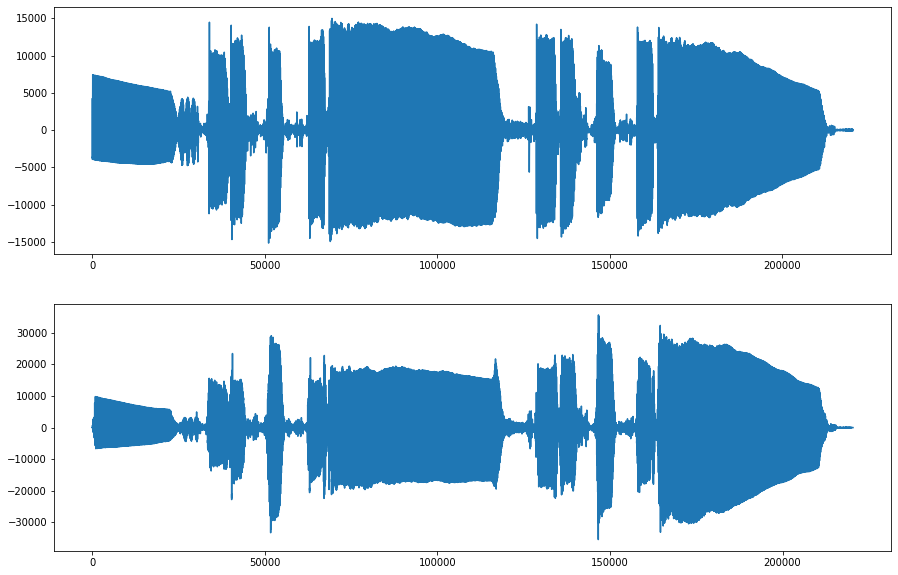

In [ ]:


NS=len(a[1])
Son=a[1]
rec=8
N=1024
Fe=44100


TF = TFCourtTerme(Son,N,rec)
#T = np.linspace(0,len(TF[0])-2,int(len(TF[0])*0.5))
#T = np.linspace(0,len(TF[0])-2,int(len(TF[0])*2))
T = np.linspace(0,len(TF[0])-2,int(len(TF[0])))
spectre = np.abs(TF)
phase = np.angle(TF)

ispectre = InterpSpec(spectre,T)
iphase = InterpPhase(phase,T)
iTF = ispectre*np.exp(complex(0,1)*iphase)

Sonrec = RecSon(iTF,rec)



plt.figure(figsize = (15,10))
plt.subplot(2, 1, 1)
plt.plot(a[1])
plt.subplot(2, 1, 2)
plt.plot(Sonrec)
plt.show()
Audio(Sonrec, rate=Fe)
